### 1 Training Data Preparation

95 features are considered too many features. The number of features must be reduced to increase the
efficiency of the model. The maximum number of features a team can have is 50.
1. PCA is not allowed to reduce the original dimensions. It can be used only after features are modified via extraction or engineering. More than 95% of information must be kept when PCA is performed. PCA can be a good strategy at the last stage of training the data, and it is optional.
2. An original feature can be kept if and only if non-linearity is confirmed. Otherwise, it must be feature engineered.
3. A feature can be extracted if and only if it holds a strong positive or negative correlation between other features (not to the target). The correlation coefficient |ρ| ≥ 0.95 considers the strong correlation.
4. The normality of each feature must be confirmed.

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro

# Load your data
data = pd.read_csv('train_data.csv')
data.head(10)


# Trim whitespace from column names
data.columns = data.columns.str.strip()

# Verify column names
print(data.columns)



Index(['Index', 'Bankrupt?',
       'ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth R

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from scipy.stats import normaltest

# Load and clean data
data = pd.read_csv('train_data.csv')
data.columns = data.columns.str.strip()
labels = data['Bankrupt?']

# Non-feature columns and target variable dropped
data = data.drop(columns=['Bankrupt?', 'Index'])

# Scaling data using RobustScaler to minimize outlier impact
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data.select_dtypes(include=[np.number]))
data_scaled = pd.DataFrame(data_scaled, columns=data.select_dtypes(include=[np.number]).columns)

# Combining highly correlated features
composite_features = {
    'Liability_Composite': (data_scaled['Current Liabilities/Liability'] + data_scaled['Current Liability to Liability']) / 2,
    'Net_Value_Per_Share_BC': (data_scaled['Net Value Per Share (B)'] + data_scaled['Net Value Per Share (C)']) / 2,
    'Interest_Rate_Composite': (data_scaled['Pre-tax net Interest Rate'] + data_scaled['After-tax net Interest Rate']) / 2,
    'Gross_Margin_Composite': (data_scaled['Operating Gross Margin'] + data_scaled['Gross Profit to Sales']) / 2,
    'EPS_Net_Profit_Composite': (data_scaled['Persistent EPS in the Last Four Seasons'] + data_scaled['Per Share Net profit before tax (Yuan ¥)']) / 2
}
data_scaled = data_scaled.assign(**composite_features)
data_scaled.drop(columns=list(composite_features.keys()), inplace=True)

# Normality check and transformation
for column in data_scaled.columns:
    _, p = normaltest(data_scaled[column])
    if p < 0.05:  # Not normal
        # Clipping data to avoid extremes before transformation
        clipped_data = np.clip(data_scaled[column], -10, 10)
        transformer = PowerTransformer(method='yeo-johnson')
        data_scaled[column] = transformer.fit_transform(clipped_data.values.reshape(-1, 1))

# Apply PCA to ensure no more than 50 components and at least 95% variance retention
pca = PCA(n_components=0.95)
transformed_data = pca.fit_transform(data_scaled)

if pca.n_components_ > 50:
    pca = PCA(n_components=50)
    transformed_data = pca.fit_transform(data_scaled)

print(f"Components used: {pca.n_components_}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")


Components used: 40
Explained variance ratio: 0.9533278841966508


Before applying PCA, features were engineered by combining them based on strong correlations, effectively reducing the number of original features while hopefully capturing similar information.

Then, PCA was applied, configured to retain components that explain at least 95% of the variance, which ensures that the dimensional reduction does not significantly lose important information. 

### 2 Company Characterization

Understanding every company’s situation is quite difficult at a given time. However, knowing the general
situation will greatly help model training. The easiest approach is finding the common characteristics
between similar companies, and similar companies can easily be grouped by using unsupervised learning
clustering techniques.
1. Find k or more subgroups by KMeans or Gaussian Mixture where k is higher or equal to the number of members in each team. When the clustering technique is applied, the target must be dropped, and the technique must not be applied to the original feature space.
2. Identify unique or helpful characteristics in each subgroup. Use visualization techniques to present identified characteristics.
3. Keep the cluster IDs. It will be used later in Section 3.


C:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

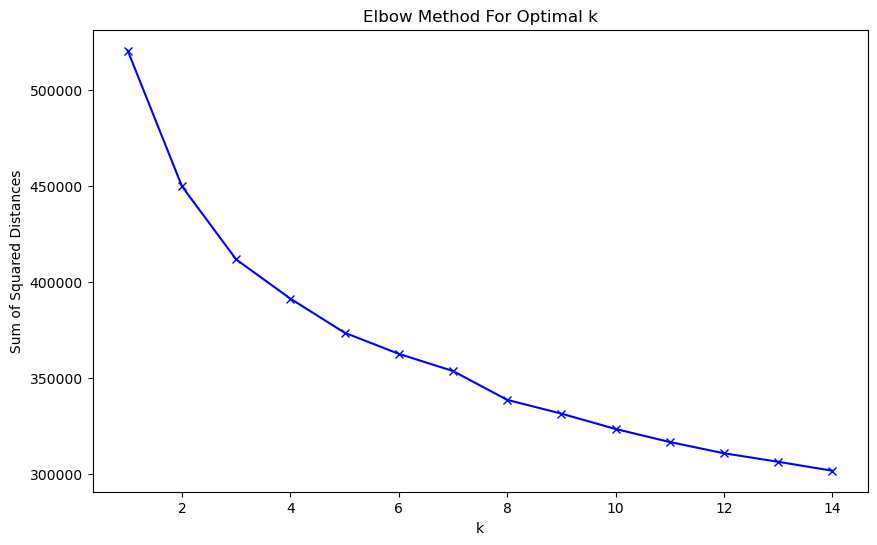

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

# Implementing the Elbow Method to find the optimal number of clusters
sum_of_squared_distances = []
K_range = range(1, 15)  # You can adjust the range based on your dataset and expectations

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(transformed_data)
    sum_of_squared_distances.append(km.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()


We can see by elbow method that the optimal k is around 3.

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


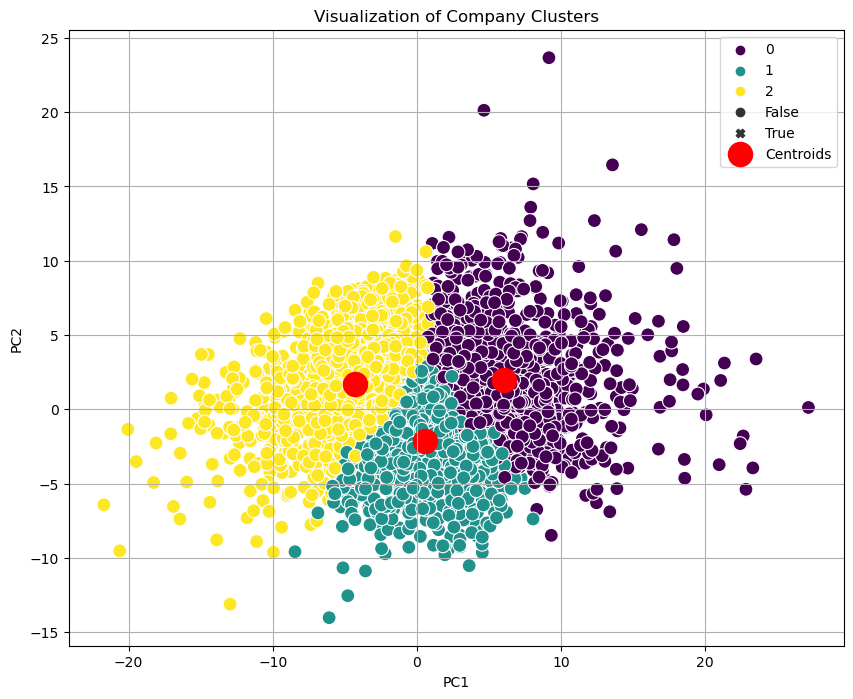

In [18]:
# recall: 'transformed_data' is the PCA reduced data
# number of clusters (k) 
k = 3

# initialize KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)

# fit KMeans to the transformed data
clusters = kmeans.fit_predict(transformed_data)

# 'clusters' contains the cluster IDs assigned by KMeans to each data point

pca_df = pd.DataFrame(transformed_data, columns=[f'PC{i+1}' for i in range(transformed_data.shape[1])])
pca_df['Cluster_ID'] = clusters  # clusters obtained from KMeans

# calculating cluster centers directly from PCA data for accurate plotting
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(kmeans.cluster_centers_.shape[1])])
cluster_centers['Cluster_ID'] = range(k)  # Assign unique IDs to cluster centers for plotting

# combining data and cluster centers for plotting
plot_data = pd.concat([pca_df, cluster_centers], ignore_index=True)

# visualization using the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_ID', data=plot_data, style=plot_data.index >= len(pca_df), palette='viridis', s=100)
plt.scatter(cluster_centers['PC1'], cluster_centers['PC2'], s=300, c='red', label='Centroids')  # Highlight centroids
plt.title('Visualization of Company Clusters')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Calculate the number of subgroups
num_subgroups = len(set(clusters))

print("Number of Subgroups:", num_subgroups)

# Iterate over each cluster to identify unique characteristics
for cluster_id in range(num_subgroups):
    # Filter data points belonging to the current cluster
    cluster_data = transformed_data[clusters == cluster_id]
    
    # Calculate and print characteristics of the current cluster
    print("\nSubgroup", cluster_id)
    print("Number of Data Points:", len(cluster_data))
    print("Mean of Each Feature:")
    print(np.mean(cluster_data, axis=0))  # Calculate mean of each feature
    print("Standard Deviation of Each Feature:")
    print(np.std(cluster_data, axis=0))   # Calculate standard deviation of each feature


Number of Subgroups: 3

Subgroup 0
Number of Data Points: 1161
Mean of Each Feature:
[ 6.0687467   1.96932349 -0.34348719  0.53869843  0.54953338 -0.275004
  0.22402145 -0.12998328  0.37381506 -0.42798301  1.09785746 -0.14150467
  0.17407091  0.1042085  -0.06417857  0.09415152 -0.10767958  0.01496709
  0.07691315  0.0616707   0.02500017  0.02153024  0.05964301 -0.01302528
 -0.03653983 -0.05232052  0.01204047  0.0439849  -0.02377657 -0.01767866
 -0.02202354 -0.0160978  -0.0761107  -0.04925689  0.01235444 -0.04208778
  0.03569944 -0.02324286  0.03158193  0.02744033]
Standard Deviation of Each Feature:
[3.67580595 3.52594812 2.96512666 2.386586   2.37848586 3.37617698
 2.03091221 1.71403833 1.74510153 2.09258834 1.8379267  1.80038021
 1.85957993 1.63492915 1.46723332 1.46735898 1.24738539 1.21714787
 1.00878351 1.19377679 1.10922139 0.98753904 1.01640789 1.07081595
 1.02985907 0.93922748 0.93770665 1.01854352 0.9571029  0.88005932
 0.87921128 1.02995368 0.74604161 0.92093661 0.89533602 0.

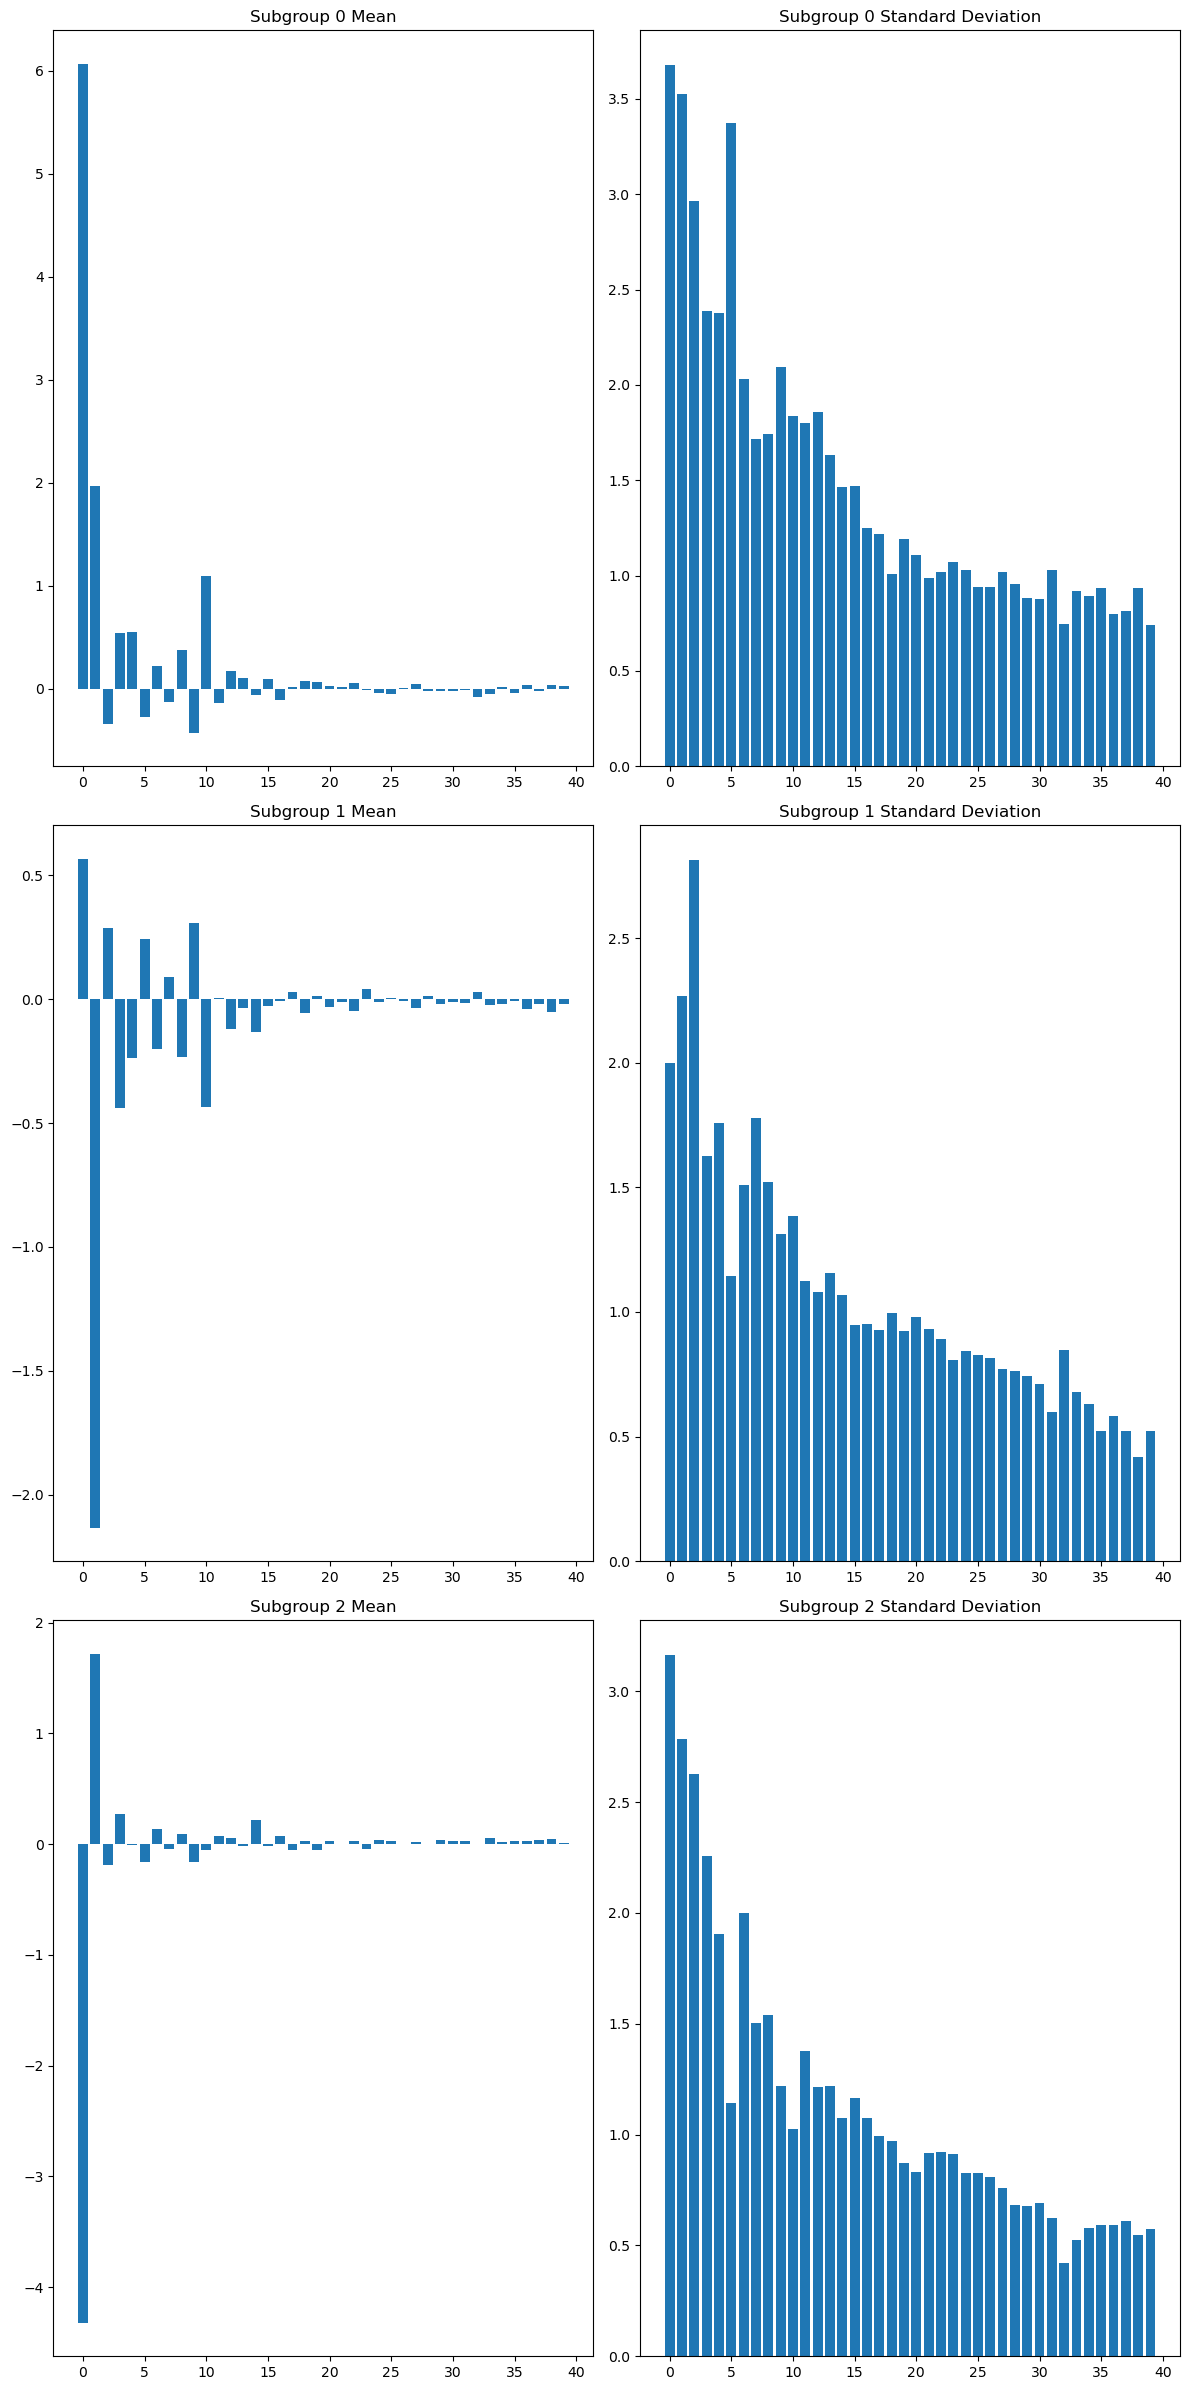

In [21]:
import matplotlib.pyplot as plt

# Calculate the number of subgroups
num_subgroups = len(set(clusters))

# Set up subplots
fig, axs = plt.subplots(num_subgroups, 2, figsize=(12, 8*num_subgroups))

# Iterate over each cluster to identify unique characteristics
for cluster_id in range(num_subgroups):
    # Filter data points belonging to the current cluster
    cluster_data = transformed_data[clusters == cluster_id]
    
    # Calculate mean and standard deviation of each feature within the current cluster
    mean_values = np.mean(cluster_data, axis=0)
    std_values = np.std(cluster_data, axis=0)
    
    # Plot mean values
    axs[cluster_id, 0].bar(range(len(mean_values)), mean_values)
    axs[cluster_id, 0].set_title(f'Subgroup {cluster_id} Mean')
    
    # Plot standard deviation values
    axs[cluster_id, 1].bar(range(len(std_values)), std_values)
    axs[cluster_id, 1].set_title(f'Subgroup {cluster_id} Standard Deviation')

# Add labels and adjust layout
plt.tight_layout()
plt.show()


In [22]:
# Create lists to store subgroup characteristics
subgroup_means = []
subgroup_stds = []

# Iterate over each cluster to identify unique characteristics
for cluster_id in range(num_subgroups):
    # Filter data points belonging to the current cluster
    cluster_data = transformed_data[clusters == cluster_id]
    
    # Calculate mean and standard deviation of each feature within the current cluster
    mean_values = np.mean(cluster_data, axis=0)
    std_values = np.std(cluster_data, axis=0)
    
    # Append mean and standard deviation to respective lists
    subgroup_means.append(mean_values)
    subgroup_stds.append(std_values)

# Convert lists to arrays for easier manipulation
subgroup_means = np.array(subgroup_means)
subgroup_stds = np.array(subgroup_stds)

# Calculate summary statistics for standard deviation across subgroups
std_means = np.mean(subgroup_stds, axis=1)
std_max = np.max(subgroup_stds, axis=1)
std_min = np.min(subgroup_stds, axis=1)

# Identify subgroup with the greatest standard deviation
max_std_index = np.argmax(std_means)
max_std_subgroup = max_std_index
max_std_mean = std_means[max_std_index]
max_std_min = std_min[max_std_index]
max_std_max = std_max[max_std_index]

print("Subgroup with Greatest Standard Deviation:")
print(f"Subgroup: {max_std_subgroup}")
print(f"Mean Standard Deviation: {max_std_mean}")
print(f"Min Standard Deviation: {max_std_min}")
print(f"Max Standard Deviation: {max_std_max}")


Subgroup with Greatest Standard Deviation:
Subgroup: 0
Mean Standard Deviation: 1.4816248029875727
Min Standard Deviation: 0.7395855230906113
Max Standard Deviation: 3.6758059471128264
